<a href="https://colab.research.google.com/github/andiylan/Microepression/blob/main/MedianGabor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install scikit-image

In [ ]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from skimage.color import rgb2gray


In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Konfigurasi Gabor Filter

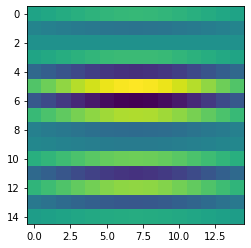

In [10]:
ksize = 15 #ukuran kernel
sigma = 5 #bobot fitur
theta = 1*np.pi/2  #orientasi
lamda = 3*np.pi/4  #arah orientasi
gamma = 0.9  #aspect ratio
phi = 0.8  #offset

kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)
plt.imshow(kernel)

prepare dataset

In [ ]:
dataset_folder = "/content/drive/MyDrive/SMIC_HS/Train/"

names = []
images = []
for folder in os.listdir(dataset_folder):
    for name in os.listdir(os.path.join(dataset_folder, folder)):
            img = cv2.imread(os.path.join(dataset_folder + folder, name))
            img = cv2.medianBlur(img, 3)
            img = cv2.filter2D(img, cv2.CV_8UC3, kernel)
            img = cv2.resize(img, (100, 100))
            img = rgb2gray(img)
            kernel_resized = cv2.resize(kernel,(400,400))
            images.append(img)
            names.append(folder)

In [11]:
labels=np.unique(names)
labels

array(['negative', 'positive', 'surprise'], dtype='<U8')

In [15]:
def show_dataset(images_class, label):
    # show data for 1 class
    plt.figure(figsize=(14,5))
    k = 0
    for i in range(1,6):
        plt.subplot(1,5,i)
        try :
            plt.imshow(images_class[k][:,:,:,:-1])
        except :
            plt.imshow(images_class[k],cmap='gray')
        plt.title(label)
        plt.axis('off')
        plt.tight_layout()
        k += 1
    plt.show()

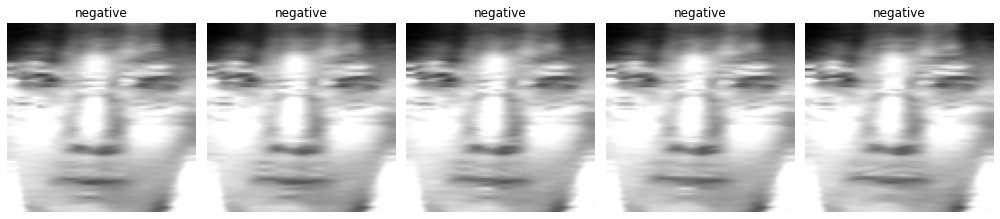

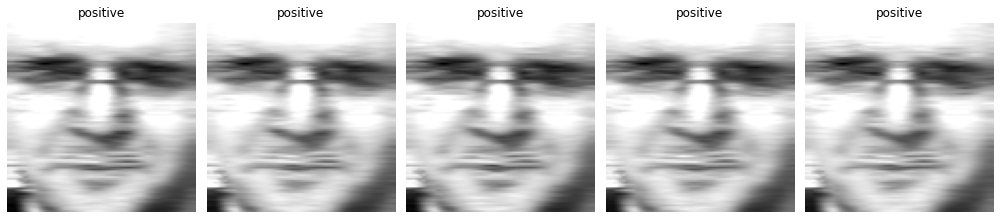

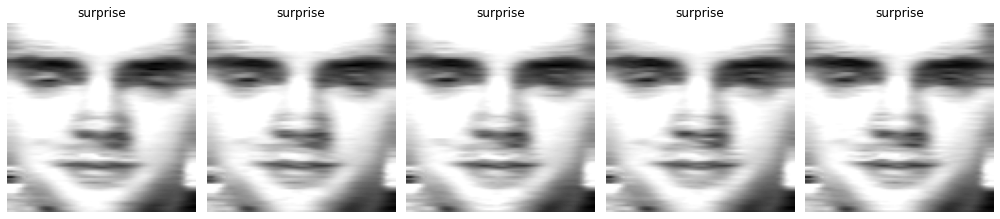

In [16]:
for label in labels:
    
    ids = np.where(label== np.array(names))[0]
    images_class = images[ids[0] : ids[-1] + 1] # select croped images for each class
    show_dataset(images_class, label)

Label Encoding

In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
le = LabelEncoder()

le.fit(names)

LabelEncoder()

In [19]:
name_vec=le.transform(names)

In [20]:
name_vec

array([2, 2, 2, ..., 1, 1, 1])

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
x_train, x_test, y_train, y_test = train_test_split(
                                                    np.array(images),
                                                    np.array(name_vec),
                                                    test_size=0.25, 
                                                    random_state=42)

In [23]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4144, 100, 100), (4144,), (1382, 100, 100), (1382,))

In [24]:
from skimage.feature import local_binary_pattern

In [25]:
P = 8
R = 1
img = x_train[0]
lbp_img = local_binary_pattern(img, P=P, R=R, method="default")

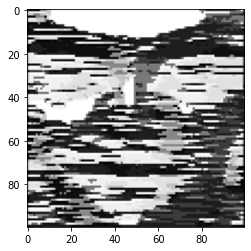

In [26]:
plt.imshow(lbp_img, cmap="gray")

In [27]:
H = np.histogram(lbp_img.ravel(),                          
                 bins=2**P,                          
                 range=(0, 2**P),
                 density=True)[0] 


In [28]:
print(H)

[0.0061 0.0272 0.0002 0.0096 0.0001 0.0002 0.001  0.0224 0.0001 0.0001
 0.     0.0001 0.0016 0.0005 0.0051 0.0705 0.0328 0.0064 0.     0.0003
 0.0001 0.     0.0004 0.0009 0.0155 0.0004 0.     0.     0.0418 0.0005
 0.0889 0.0249 0.0005 0.0003 0.     0.0001 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.0001 0.0001 0.0102 0.0003
 0.0001 0.     0.     0.     0.     0.     0.0149 0.0001 0.     0.
 0.0251 0.     0.0339 0.0006 0.0003 0.0001 0.     0.     0.     0.
 0.     0.0001 0.     0.     0.     0.     0.     0.     0.     0.0001
 0.0003 0.0001 0.     0.     0.     0.     0.     0.     0.     0.0001
 0.     0.     0.0001 0.     0.     0.     0.0023 0.0002 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0006 0.
 0.0004 0.0002 0.0153 0.0006 0.     0.     0.     0.     0.     0.
 0.0137 0.0002 0.     0.     0.017  0.0005 0.021  0.0026 0.     0.0068
 0.     0.0103 0.     0.     0.     0.0165 0.     0.     0.     0.
 0.     0.     0.     0.0168 0.   

<function matplotlib.pyplot.show>

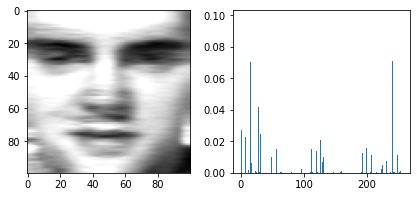

In [29]:
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")

plt.subplot(1,2,2)
axis = np.arange(len(H))
plt.bar(axis, H)

plt.show

In [30]:
lbph = cv2.face.LBPHFaceRecognizer_create()
lbph.train(x_train, y_train)

In [31]:
y_predict = [lbph.predict(x)[0] for x in x_test]

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [33]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6, 6))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [34]:
class LBPH_SVM_Recognizer_V1():
    #
    # ----- class for LBPH Scikit + SVM OpenCV------
    #
    def __init__(self, max_iter=100, epsilon=0.001, C=100, Gamma=0.001):
        self.svm = cv2.ml.SVM_create()
        self.svm.setKernel(cv2.ml.SVM_CHI2)
        self.svm.setType(cv2.ml.SVM_C_SVC)
        self.svm.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, max_iter, epsilon))
        self.svm.setC(C)           
        self.svm.setGamma(Gamma) 
        
        self.face_histograms = []
        self.y = []
    
    def find_lbp_histogram(self, image, P=8, R=1, eps=1e-7, n_window=(8,8)):
        E = []
        h, w = image.shape
        h_sz = int(np.floor(h/n_window[0]))
        w_sz = int(np.floor(w/n_window[1]))
        lbp_img = local_binary_pattern(image, P=P, R=R, method="default")
        for (x, y, C) in self.sliding_window(lbp_img, stride=(h_sz, w_sz), window=(h_sz, w_sz)):
            if C.shape[0] != h_sz or C.shape[1] != w_sz:
                continue
            H = np.histogram(C,                          
                             bins=2**P, 
                             range=(0, 2**P),
                             density=True)[0] 
            E.extend(H)
        return E
    
    def sliding_window(self, image, stride, window):
        for y in range(0, image.shape[0], stride[0]):
            for x in range(0, image.shape[1], stride[1]):
                yield (x, y, image[y:y + window[1], x:x + window[0]])
                   
    def train(self, x, y):
        self.y = y
        self.face_histograms = [self.find_lbp_histogram(img) for img in x]
        hist_mat = np.array(self.face_histograms, dtype=np.float32)
        self.svm.train(hist_mat, cv2.ml.ROW_SAMPLE, y)
    
    def predict(self, x):
        hists = [self.find_lbp_histogram(img) for img in x]
        hist_mat = np.array(hists, dtype=np.float32)
        ret, idx = self.svm.predict(hist_mat, True)
        confidence = 1.0 / (1.0 + np.exp(-ret)) # convert retVal to confidence level (0-1) sigmoid
        return idx, confidence

In [35]:
lbph_svm_model_v1 = LBPH_SVM_Recognizer_V1()

In [36]:
lbph_svm_model_v1.train(x_train, y_train)

In [37]:
lbph_svm_model_v1.svm.save("lbph_svm_model_v1.yml")
lbph_svm_model_v1.svm.load("lbph_svm_model_v1.yml")

<ml_SVM 0x7f16a63d2db0>

In [38]:
y_predict = lbph_svm_model_v1.predict(x_test)[0]

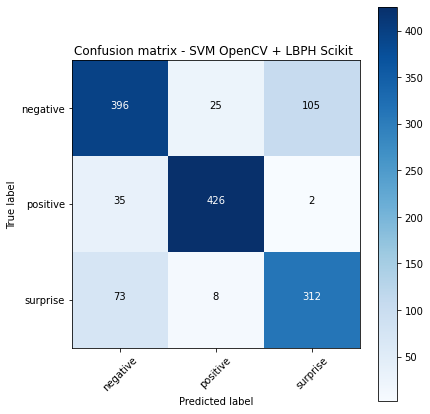

In [39]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predict)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels,normalize=False,
                      title='Confusion matrix - SVM OpenCV + LBPH Scikit ')

In [40]:
print("== Classification Report - SVM OpenCV + LBPH Scikit ==\n")
print(classification_report(y_test, 
                            y_predict, 
                            target_names=labels))

== Classification Report - SVM OpenCV + LBPH Scikit ==

              precision    recall  f1-score   support

    negative       0.79      0.75      0.77       526
    positive       0.93      0.92      0.92       463
    surprise       0.74      0.79      0.77       393

    accuracy                           0.82      1382
   macro avg       0.82      0.82      0.82      1382
weighted avg       0.82      0.82      0.82      1382

